In [307]:
## following the example in Chapter 5 of SNAFS
import sys
import os
import csv 
import math
import numpy as np
import networkx as net
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (21, 14)
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
import plotly.tools as tls
#tls.set_credentials_file(username='tdetz', api_key='705bdng1xl')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
from networkx import algorithms
import pandas as pd
import triadic
import draw_triads

In [70]:
## SNAFS: Import bi-partite (bi-modal) functions
from networkx.algorithms import bipartite as bi

def trim_edges(g, weight=1):
    g2=net.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

In [26]:
## SNAFS: get a sorted degree list to obtain topmost nodes
def sorted_map(map):
    ms = sorted(map.iteritems(), key = lambda (k, v): (-v, k))
    return ms

In [27]:
## read in the pac expenditure data
spacs=pd.read_csv("spacs.csv")

In [331]:
spacs.head(2)

,cand_ID,candidate,pac_ID,pac,election,office_state,district,office,party,amount,exp_dat,sup_opp,exp_cat,paid_To
0,P80001571,Trump Donald,C90006149,PLANNED PARENTHOOD ADVOCACY PROJECT LOS ANGELE...,P,CA,0,P,,5003,5/28/16,Oppose,MAILER,null
1,P00003392,Clinton Hillary,C00489799,Planned Parenthood Votes,G,US,0,P,Dem,2050,7/27/16,Support,Online video production-Estimated costs,76 Words


In [29]:
## check to be sure we have the right pacs
pacs_agg = spacs.groupby(['pac_ID', 'pac'], as_index=False)['amount'].sum()

In [30]:
### looks like the pac names aren't standardized; would help with the final graphic to clean them up

In [332]:
## top half by spending
pacs_agg.sort_values(['amount'], ascending=False)[0:9]

,pac_ID,pac,amount
147,C00616078,"GET OUR JOBS BACK, INC",100020332
91,C00571372,Right to Rise USA,87042468
49,C00495861,Priorities USA Action,72882378
69,C00541292,Conservative Solutions PAC,58668666
137,C00608489,GREAT AMERICA PAC,23774300
149,C00618876,Rebuilding America Now,20841357
96,C00573055,America Leads,19639040
133,C00603621,Our Principles PAC,19039615
115,C00581868,New Day for America,11430221


In [32]:
## get pacs that spent more than median
trim_pacs = pacs_agg[pacs_agg.amount > pacs_agg.amount.median()]

In [33]:
top_spenders = list(trim_pacs['pac_ID'].unique())

In [34]:
## check to be sure
len(top_spenders)

108

In [35]:
## limit data to top spending pacs
new_pacs = spacs[spacs['pac_ID'].isin(top_spenders)]

In [36]:
## slice the underlying data
new_pacs_agg = new_pacs.groupby(['pac_ID', 'pac', 'candidate', 'sup_opp'], as_index=False)['amount'].sum()

In [78]:
new_pacs_agg.head()


,pac_ID,pac,candidate,sup_opp,amount
0,C00002766,UNITED FOOD AND COMMERCIAL WORKERS INTERNATION...,Clinton Hillary,Support,142727
1,C00003418,REPUBLICAN NATIONAL COMMITTEE,Clinton Hillary,Oppose,805939
2,C00004036,SEIU COPE (Service Employees International Uni...,Bush Jeb,Oppose,164950
3,C00004036,SEIU COPE (Service Employees International Uni...,Clinton Hillary,Support,1998649
4,C00004036,SEIU COPE (Service Employees International Uni...,Cruz Ted,Oppose,422486


In [38]:
## try using example in nx docs for a bipartite graph
N = net.DiGraph()

In [39]:
## these for use later, to switch focus
pacs = list(new_pacs['pac_ID'].unique())
cands = list(new_pacs['candidate'].unique())

In [40]:
N.add_nodes_from(pacs, bipartite=0) 
N.add_nodes_from(cands, bipartite=1) 

In [41]:
## add edges and attributes (amount spent and whether oppose or support)
for row in range(0, len(new_pacs_agg)):
    N.add_edge(new_pacs_agg.iloc[row][0], new_pacs_agg.iloc[row][2], weight=new_pacs_agg.iloc[row][4])

In [42]:
## check to see if it's a digraph, though I'm not sure how to add direction to the edges
net.is_directed(N)

True

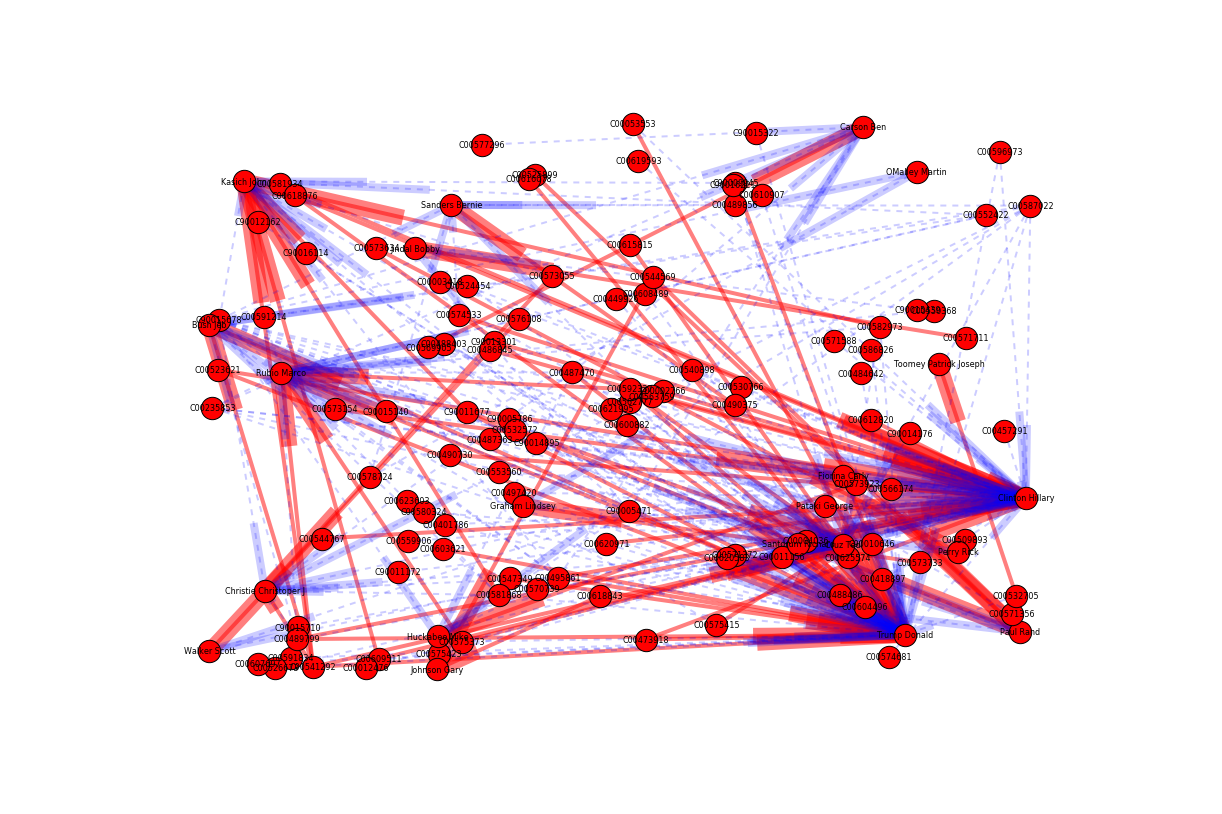

In [311]:
## plot it
pos=net.random_layout(N) # positions for all nodes

elarge=[(u,v) for (u,v,d) in N.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in N.edges(data=True) if d['weight'] <=1000000]

# nodes
net.draw_networkx_nodes(N,pos,node_size=500)
# edges
net.draw_networkx_edges(N,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(N,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(N,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [45]:
## some statistics

n, k = N.order(), N.size()
avg_deg = float(k) / n

print "Nodes: ", n
print "Edges: ", k
print "Average degree: ", avg_deg
print "Strongly Connected Components: ", net.number_strongly_connected_components(N)
print "Weakly Connected Components: ", net.number_weakly_connected_components(N)

Nodes:  129
Edges:  235
Average degree:  1.82170542636
Strongly Connected Components:  129
Weakly Connected Components:  1


In [46]:
in_degrees = N.in_degree() # dictionary node:degree
in_values = sorted(set(in_degrees.values()))
in_hist = [in_degrees.values().count(x) for x in in_values]

In [47]:
out_degrees = N.out_degree() # dictionary node:degree
out_values = sorted(set(out_degrees.values()))
out_hist = [out_degrees.values().count(x) for x in out_values]

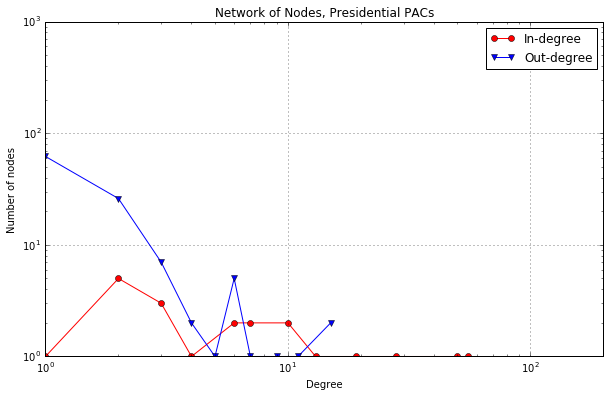

In [48]:
plt.figure() # you need to first do 'import pylab as plt'
plt.grid(True)
plt.loglog(in_values, in_hist, 'ro-') # in-degree
plt.loglog(out_values, out_hist, 'bv-') # out-degree
plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Network of Nodes, Presidential PACs')
plt.xlim([0, 2*10**2])
plt.show()
## plt.savefig('g2_degree_distribution.pdf')
## plt.close()

In [49]:
## to get centrality measures, must convert to undirected graph
N_ud = N.to_undirected()

In [50]:
## Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = net.clustering(N_ud)

## Average clustering coefficient
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
print avg_clust

## Or use directly the built-in method
print net.average_clustering(N_ud)

0.0
0.0


In [192]:
# Connected components are sorted in descending order of their size
N_components = list(net.connected_component_subgraphs(N_ud))
N_mc = N_components[0]

# Betweenness centrality
bet_cen = net.betweenness_centrality(N_ud)

# Closeness centrality
clo_cen = net.closeness_centrality(N_ud)

# Eigenvector centrality
eig_cen = net.eigenvector_centrality_numpy(N_ud)

# Degree centrality
deg_cen = net.degree_centrality(N_ud)

In [270]:
## utility function to get topmost nodes for each centrality function
def get_top_keys(dictionary, top):
    items = dictionary.items()
    items.sort(reverse=True, key=lambda x: x[1])
    return map(lambda x: x, items[:top])

In [271]:
## get the top nodes
top_bet_cen = get_top_keys(bet_cen,10)
top_clo_cen = get_top_keys(clo_cen,10)
top_eig_cen = get_top_keys(eig_cen,10)
top_deg_cen = get_top_keys(deg_cen, 10)

In [291]:
## smush them together to make a comparison chart
smush = np.hstack((top_bet_cen, top_clo_cen, top_eig_cen, top_deg_cen))

In [292]:
cent_measures=pd.DataFrame(smush, columns=['Node', 'Betweenness', 'Node', 'Closeness', 'Node', 'Eigenvector', 'Node', 'Degree'])

In [293]:
cent_measures

,Node,Betweenness,Node,Closeness,Node,Eigenvector,Node,Degree
0,Trump Donald,0.429085642504,Trump Donald,0.496124031008,Trump Donald,0.706732522196,Trump Donald,0.4296875
1,Clinton Hillary,0.398163898126,C90015678,0.494208494208,C00616078,0.573916656874,Clinton Hillary,0.390625
2,C90015678,0.175236472296,C90005471,0.490421455939,C00495861,0.385719642081,Cruz Ted,0.21875
3,C90005471,0.167796421046,Clinton Hillary,0.474074074074,C00603621,0.10924930932,Rubio Marco,0.1484375
4,Cruz Ted,0.1375054212,C00495861,0.458781362007,C00487470,0.0448704608821,C90015678,0.1171875
5,Paul Rand,0.0776193043104,C00587022,0.445993031359,C00615815,0.0416141099457,C90005471,0.1171875
6,C00495861,0.0652898972787,C00235853,0.425249169435,C90011677,0.0388911481994,Kasich John,0.1015625
7,Rubio Marco,0.0638463322083,C00489799,0.422442244224,C00523621,0.0380092394015,C00495861,0.0859375
8,Sanders Bernie,0.0585700555679,C00004036,0.416938110749,C00541292,0.0310886311414,Christie Christoper J,0.078125
9,C00587022,0.0576449525625,C00575373,0.414239482201,C00618876,0.0268487426815,Bush Jeb,0.078125


In [294]:
## top nodes by various centrality measures

table = FF.create_table(cent_measures)
py.iplot(table, filename='pandas_table')

#cent_measures

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tdetz/0 or inside your plot.ly account where it is named 'pandas_table'


In [94]:
## converts numeric output to dollar format

converter = lambda amount, currency: "%s%s%s" %(
    "-" if amount < 0 else "", 
    currency, 
    ('{:%d,.2f}'%(len(str(amount))+3)).format(abs(amount)).lstrip())

In [98]:
## How much money are we talking about?

tot = converter(sum(dict.values(net.get_edge_attributes(N, 'weight'))), '$')
print ''
print 'Total Contributions in Database:', tot


Total Contributions in Database: $554,143,291.00


In [61]:
## function to look for meaningful subgroups

def island_method(g, iterations = 5):
    weights = [edata['weight'] for f, to, edata in g.edges(data = True)]
    mn = int(min(weights))
    mx = int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step = int((mx-mn)/ iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]


In [67]:
## triadic census
census, node_census=triadic.triadic_census(N)

In [68]:
census

{'003': 323644,
 '012': 21875,
 '021C': 0,
 '021D': 466,
 '021U': 3519,
 '030C': 0,
 '030T': 0,
 '102': 0,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 0,
 '210': 0,
 '300': 0}

In [100]:
net.is_directed(N)

True

In [107]:
N2 = N.to_undirected()

In [108]:
net.is_directed(N2)

False

In [122]:
cc = max(net.connected_component_subgraphs(N2), key=len)

In [124]:
islands = island_method(cc)

In [298]:
islands

[[6, <networkx.classes.graph.Graph at 0x11ab3b150>],
 [20004071, <networkx.classes.graph.Graph at 0x11739da50>],
 [40008136, <networkx.classes.graph.Graph at 0x11739d850>],
 [60012201, <networkx.classes.graph.Graph at 0x11ab47c10>],
 [80016266, <networkx.classes.graph.Graph at 0x11ab47ed0>],
 [100020331, <networkx.classes.graph.Graph at 0x11a3641d0>]]

In [167]:
# print the threshold level, size of the graph, and number of connected components ... 
for i in islands:
    print i[0], len(i[1]), net.number_connected_components(i[1])

 6 129 1
20004071 7 3
40008136 7 3
60012201 5 2
80016266 4 2
100020331 2 1


In [185]:
## first island
testG = islands[0][1]

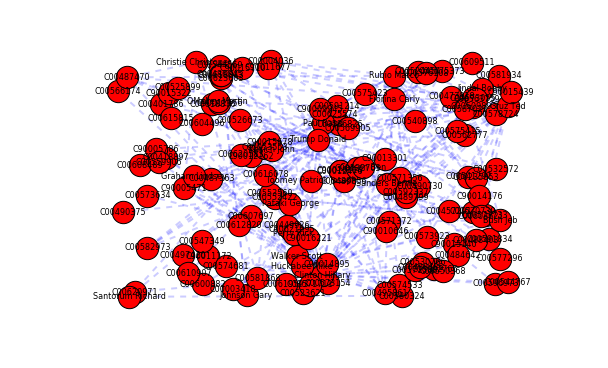

In [187]:
## plot it
pos=net.random_layout(testG) # positions for all nodes

# nodes
net.draw_networkx_nodes(testG,pos,node_size=500)
# edges
# net.draw_networkx_edges(testG,pos,width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(testG,pos,width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(testG,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [188]:
## second island
testG = islands[1][1]

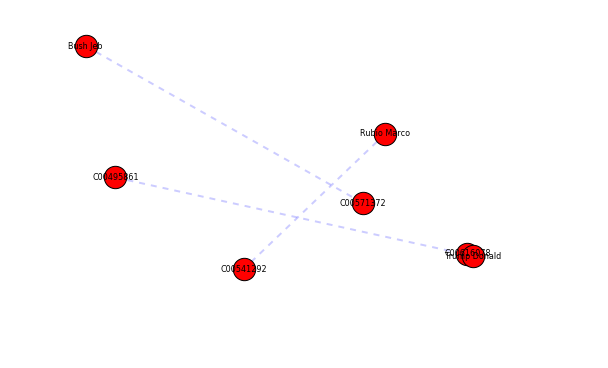

In [190]:
## plot it
pos=net.random_layout(testG) # positions for all nodes

# nodes
net.draw_networkx_nodes(testG,pos,node_size=500)
# edges
# net.draw_networkx_edges(testG,pos,width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(testG,pos,width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(testG,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [191]:
## third island
testG = islands[2][1]

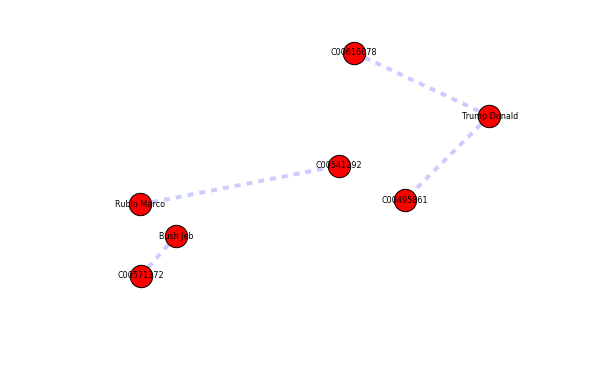

In [182]:
## plot it
pos=net.random_layout(testG) # positions for all nodes

# nodes
net.draw_networkx_nodes(testG,pos,node_size=500)
# edges
# net.draw_networkx_edges(testG,pos,width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(testG,pos,width=4,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(testG,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [ ]:
## fourth island
testG = islands[3][1]

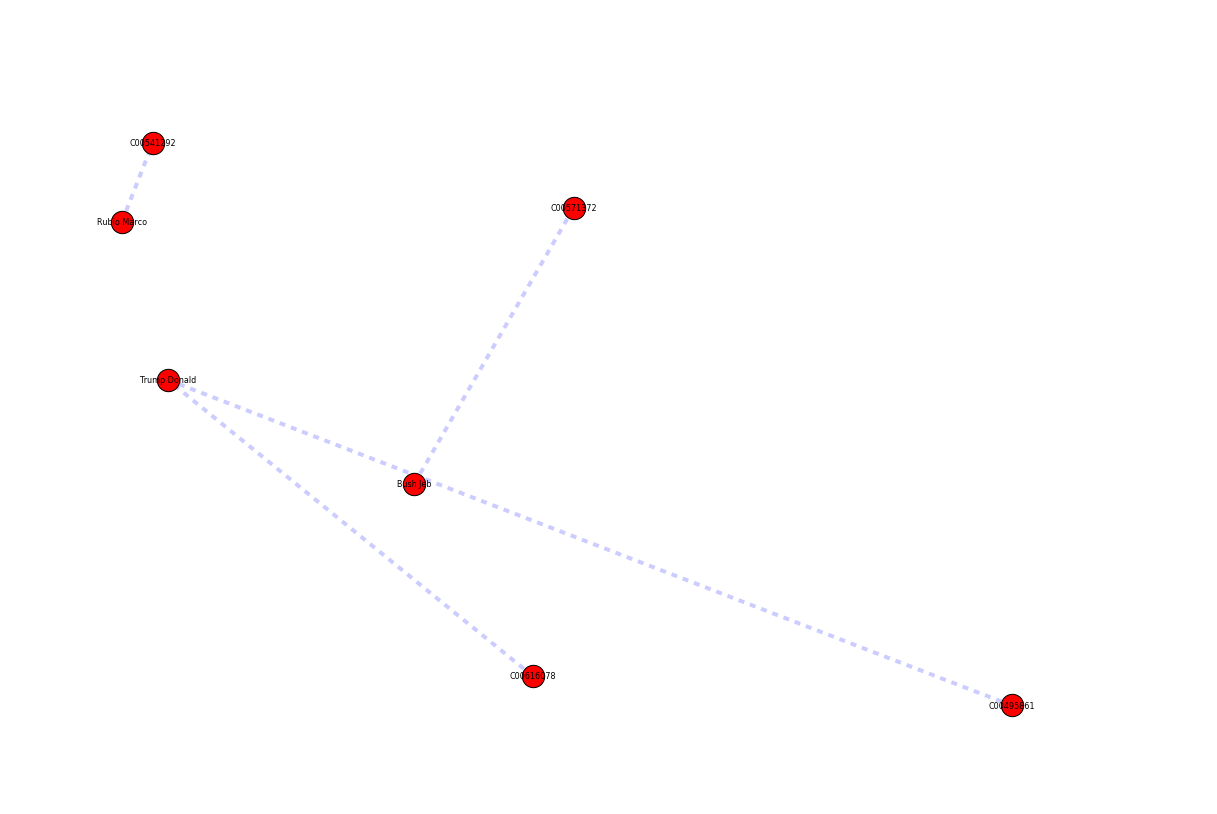

In [310]:
## plot it
pos=net.random_layout(testG) # positions for all nodes

# nodes
net.draw_networkx_nodes(testG,pos,node_size=500)
# edges
# net.draw_networkx_edges(testG,pos,width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(testG,pos,width=4,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(testG,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [300]:
## find an ego network for Hillary Clinton
hrc_graph = net.ego_graph(cc, 'Clinton Hillary', radius=2)

In [301]:
len(hrc_graph)

69

In [302]:
net.average_clustering(hrc_graph)

0.0

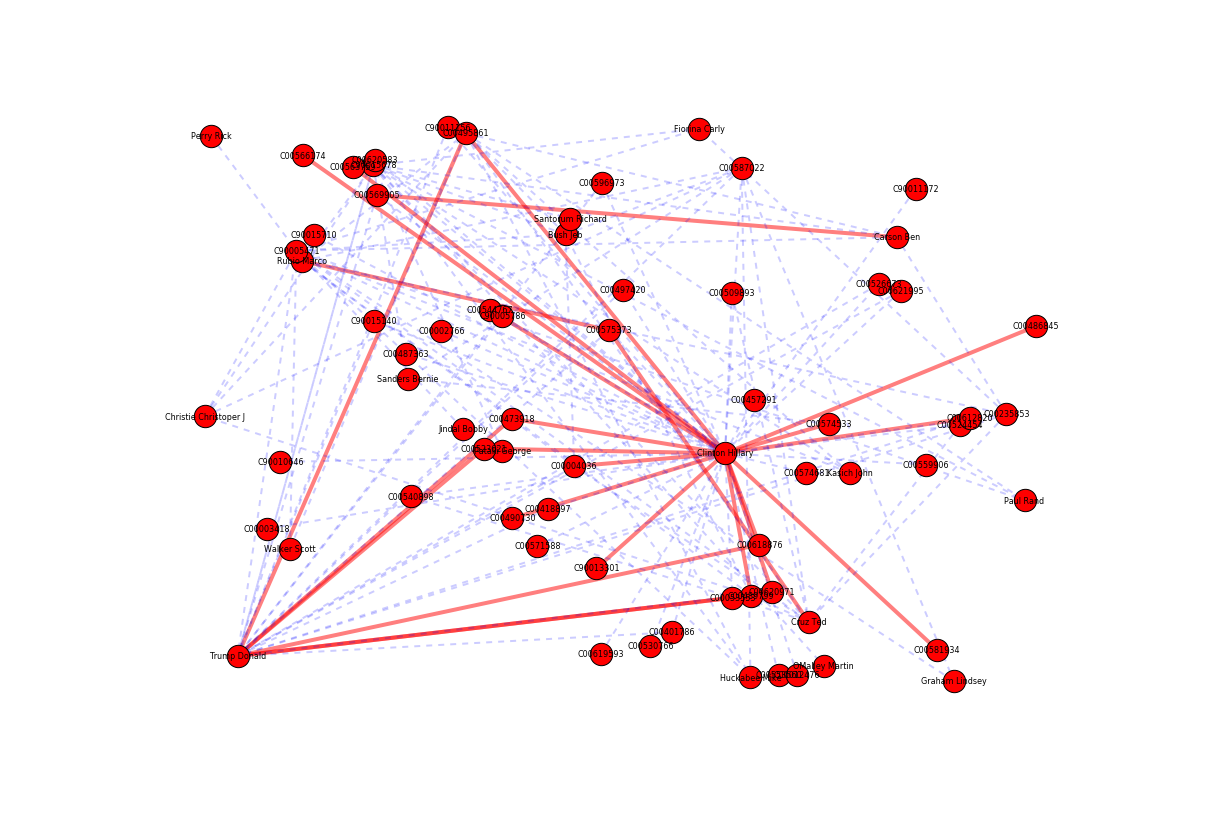

In [318]:
## plot it
pos=net.random_layout(hrc_graph) # positions for all nodes

# nodes
net.draw_networkx_nodes(hrc_graph,pos,node_size=500)

# edges
elarge=[(u,v) for (u,v,d) in hrc_graph.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in hrc_graph.edges(data=True) if d['weight'] <=1000000]
net.draw_networkx_edges(hrc_graph,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(hrc_graph,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(hrc_graph,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [323]:
## look for triads in Hillary's ego network

hrc_di=net.DiGraph(hrc_graph)

census, node_census=triadic.triadic_census(hrc_graph)

In [324]:
census

{'003': 45382,
 '012': 0,
 '021C': 0,
 '021D': 0,
 '021U': 0,
 '030C': 0,
 '030T': 0,
 '102': 4979,
 '111D': 0,
 '111U': 0,
 '120C': 0,
 '120D': 0,
 '120U': 0,
 '201': 2033,
 '210': 0,
 '300': 0}

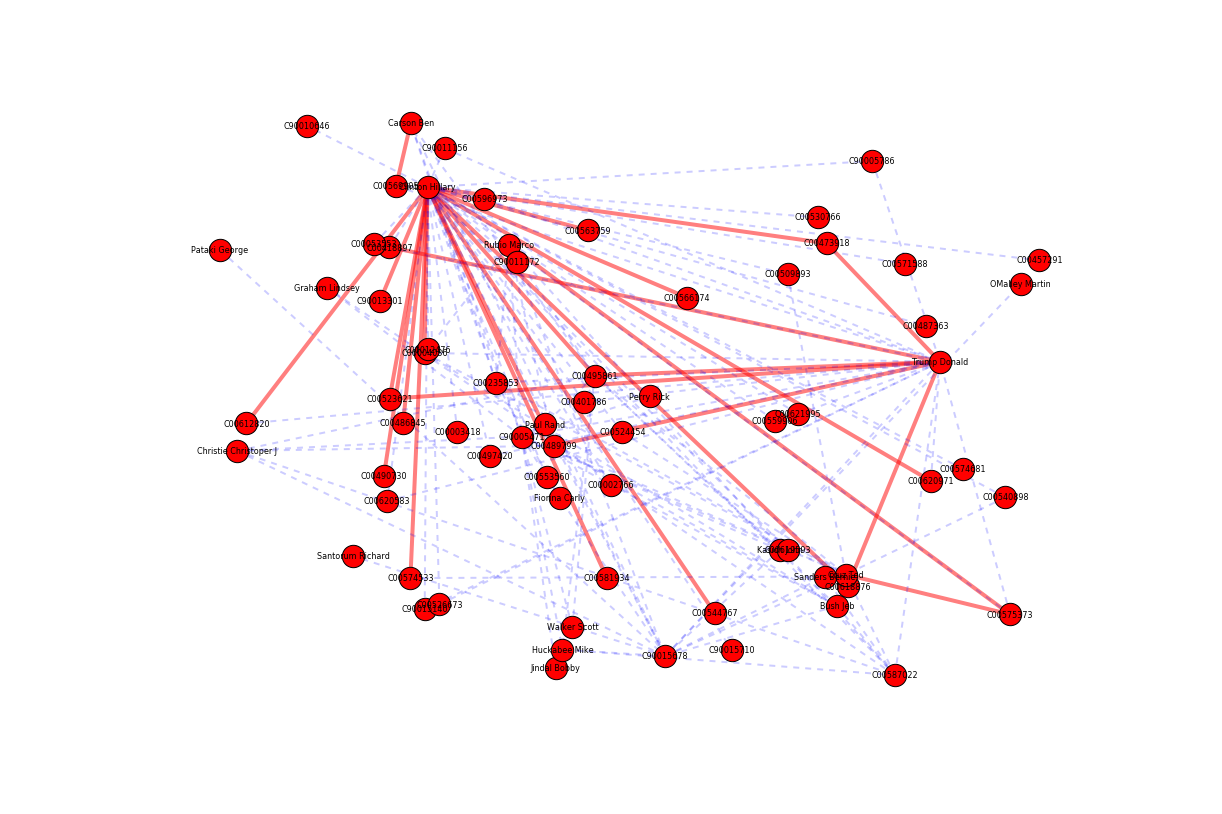

In [325]:
## plot it
pos=net.random_layout(hrc_graph) # positions for all nodes

# nodes
net.draw_networkx_nodes(hrc_graph,pos,node_size=500)

# edges
elarge=[(u,v) for (u,v,d) in hrc_graph.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in hrc_graph.edges(data=True) if d['weight'] <=1000000]
net.draw_networkx_edges(hrc_graph,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(hrc_graph,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(hrc_graph,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [334]:
## some statistics

n, k = hrc_graph.order(), hrc_graph.size()
avg_deg = float(k) / n

print "Nodes: ", n
print "Edges: ", k
print "Average degree: ", avg_deg
print "Strongly Connected Components: ", net.number_strongly_connected_components(N)
print "Weakly Connected Components: ", net.number_weakly_connected_components(N)

Nodes:  69
Edges:  135
Average degree:  1.95652173913
Strongly Connected Components:  129
Weakly Connected Components:  1


In [326]:
## find an ego network for Donald Trump
trump_graph = net.ego_graph(cc, 'Trump Donald', radius=2)

In [327]:
len(trump_graph)

75

In [329]:
net.average_clustering(trump_graph)

0.0

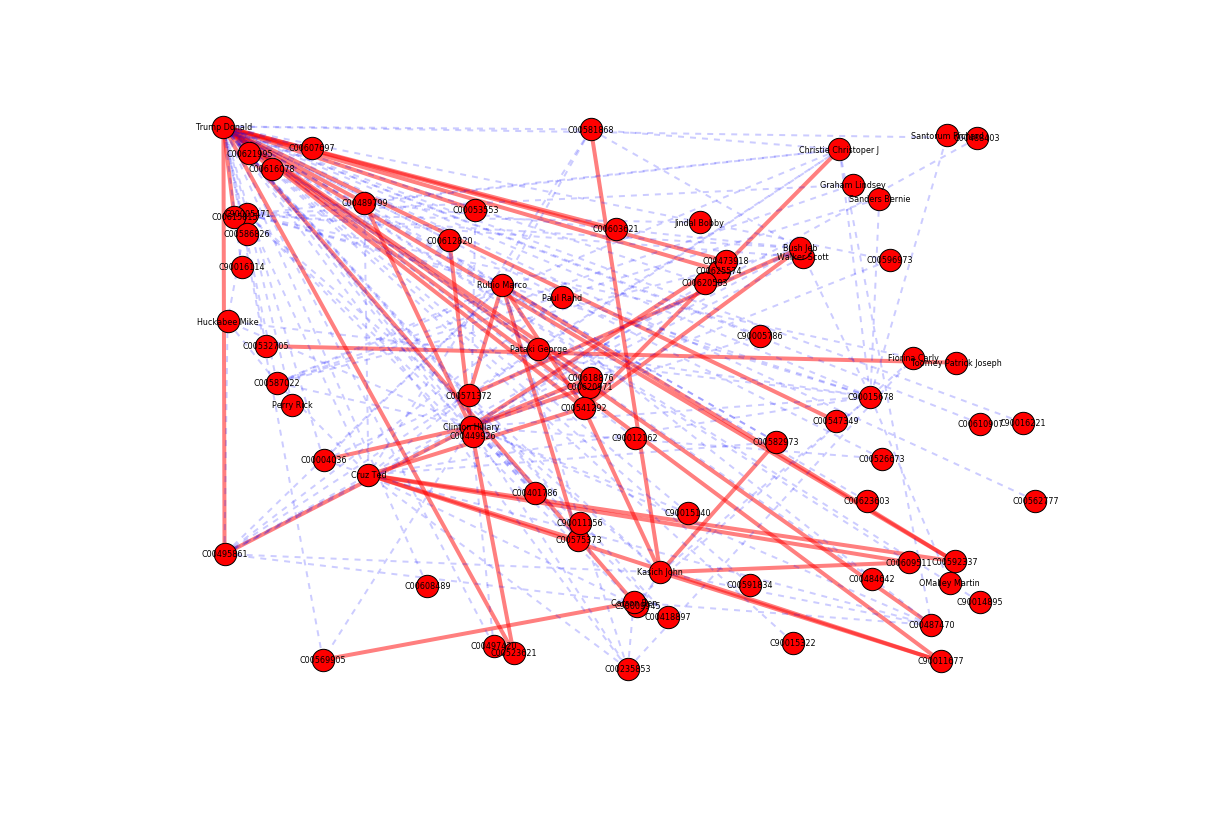

In [330]:
## plot it
pos=net.random_layout(trump_graph) # positions for all nodes

# nodes
net.draw_networkx_nodes(trump_graph,pos,node_size=500)

# edges
elarge=[(u,v) for (u,v,d) in trump_graph.edges(data=True) if d['weight'] >1000000]
esmall=[(u,v) for (u,v,d) in trump_graph.edges(data=True) if d['weight'] <=1000000]
net.draw_networkx_edges(trump_graph,pos,edgelist=elarge, width=4,alpha=0.5,edge_color='r',style='solid')
net.draw_networkx_edges(trump_graph,pos,edgelist=esmall, width=2,alpha=0.2,edge_color='b',style='dashed')

# labels
net.draw_networkx_labels(trump_graph,pos,font_size=8,font_family='sans-serif')

plt.axis('off')
plt.show()

In [333]:
## some statistics

n, k = trump_graph.order(), trump_graph.size()
avg_deg = float(k) / n

print "Nodes: ", n
print "Edges: ", k
print "Average degree: ", avg_deg
print "Strongly Connected Components: ", net.number_strongly_connected_components(N)
print "Weakly Connected Components: ", net.number_weakly_connected_components(N)

Nodes:  75
Edges:  170
Average degree:  2.26666666667
Strongly Connected Components:  129
Weakly Connected Components:  1
